In [1]:
# added to remove some of the performance warnings
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from argparse import ArgumentParser
import numpy as np
from lal import GreenwichMeanSiderealTime
from gwbench import Network

In [2]:
np.set_printoptions(linewidth=200)

parser = ArgumentParser()
parser.add_argument('--derivs', type = str, help = 'Specify wich differentiation method to use: [num, sym].', default = 'num')

parser.add_argument("-f", required=False)

_StoreAction(option_strings=['-f'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, required=False, help=None, metavar=None)

In [3]:
# choose between numeric or symbolic derivatives ['num', 'sym']
derivs = parser.parse_args().derivs

# user's choice: waveform to use
wf_model_name = 'lal_bbh'
wf_other_var_dic = {'approximant':'TaylorF2ecc'}

user_waveform = None

In [4]:
# example detector location defined by user (keep it empty if the detector tech is not custom defined )
user_locs = {}

# example detector psd defined by the user (keep it empty if the detector tech is not custom defined )
user_psds = {}

# user's choice: with respect to which parameters to take derivatives for the Fisher analysis
deriv_symbs_string = 'Mc eta DL tc phic e0 ra dec psi iota'

# user's choice: convert derivatives to cos or log for specific variables
conv_cos = ('dec', 'iota')
conv_log = ('Mc', 'DL')

# if numeric  derivatives, user's decision
use_rot = 0

# calculate SNRs, error matrices, and errors only for the network (If 1, will calculate the mentioned values only for network otherwise
# will calculate it for detectors as well as network)
only_net = 1

# = None for no parallelization, = 2,3,4,... to allocate N cores (even numbers preferred)
num_cores = None

In [5]:
# options for numeric derivative calculation
# user's choice: switch particular partial derivatives to be analytical, options = [DL,tc,phic,ra,dec,psi]
ana_deriv_symbs_string = None

# choose numdifftools parameters for numerical derivatives
step      = 1e-9
method    = 'central'
order     = 2

# only relevant for symbolic derivatives
gen_derivs = None


In [6]:
# 'user-tec_user-loc' is for custom define detector and its location
network_spec = ['ET_V', 'CE-40_H', 'CE-40_L']

print('network spec: ', network_spec)
print()

network spec:  ['ET_V', 'CE-40_H', 'CE-40_L']



In [12]:
import astropy as ap
from gwbench.utils import MTsun
from gwbench.basic_relations import DL_of_z_ap_cosmo, f_isco, f_isco_Msolar, M_of_Mc_eta, Mc_of_m1_m2, Mc_of_M_eta, eta_of_q

# Has to chosen by user
realizations=1000

# Function to generate a random individual masses from a log-uniform distribution
def log_uniform(min_val, max_val, size=realizations):
    """
    Generate a random number from a log-uniform distribution.

    Parameters:
    min_val (float): Minimum value of the distribution.
    max_val (float): Maximum value of the distribution.

    Returns:
    float: Random number from log-uniform distribution.
    """
    return np.exp(np.random.uniform(np.log(min_val), np.log(max_val), size))


# choose the individual masses acc to the lower sensitivity of the detector
mass1 = log_uniform(5, 400)
mass2 = log_uniform(5, 400)

total_mass = mass1+mass2
massRatio = mass1/mass2
Mc = Mc_of_m1_m2(mass1, mass2)
eta = eta_of_q(massRatio)

ecc = log_uniform(0.01, 0.2)

z = np.random.uniform(0, 20, size=realizations)
DL = DL_of_z_ap_cosmo(z, cosmo=None)

cos_iota = np.cos(np.random.uniform(0, np.pi, size=realizations))
cos_dec = np.cos(np.random.uniform(0, np.pi, size=realizations))

iota = np.arccos(cos_iota)
ra = np.random.uniform(0, 2 * np.pi, size=realizations)
dec = np.arccos(cos_dec)
psi = np.random.uniform(0, 2 * np.pi, size=realizations)

In [ ]:
# Store SNRs and errors for each set of parameters
snrs = []
errors = []

for i in range(realizations):
    inj_params = {
        'Mc': Mc[i]*(1+z[i]), # redshifted Mc
        'e0': ecc[i],
        'eta': eta[i],
        'chi1x': 0.,
        'chi1y': 0.,
        'chi1z': 0.,
        'chi2x': 0.,
        'chi2y': 0.,
        'chi2z': 0.,
        'DL': DL[i],
        'tc': 0.,
        'phic': 0.,
        'iota': iota[i],
        'ra': ra[i],
        'dec': dec[i],
        'psi': psi[i],
        'gmst0': 0.,
        'z': z[i],
    }
    # choose f_low acc to the detectors in the network
    f_hi = f_isco_Msolar(total_mass[i])
    df = 2.**-4
    f_lo = 3
    f = np.arange(f_lo, f_hi + df, df)

    # Initialize the Network object
    net = Network(network_spec, logger_name='CSU', logger_level='INFO')

    # Set network variables for the current injection parameters
    net.set_net_vars(
        wf_model_name=wf_model_name,
        wf_other_var_dic=wf_other_var_dic,
        user_waveform=user_waveform,
        f=f,
        inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        conv_cos=conv_cos,
        conv_log=conv_log,
        use_rot=use_rot,
        user_locs=user_locs,
        user_psds=user_psds,
        ana_deriv_symbs_string=ana_deriv_symbs_string
    )

    # Perform analysis to calculate errors and SNR
    net.calc_errors(
        only_net=only_net,
        derivs=derivs,
        step=step,
        method=method,
        order=order,
        gen_derivs=gen_derivs,
        num_cores=num_cores
    )
    
    # Extract the snr
    net.calc_snrs()
    snrs.append(net.snr)

    # Extract the error for one of the params
    # error = net.errs.get('log_Mc')
    # errors.append(error)
    errors.append(net.errs)

print("SNRs for n realizations:")
print(snrs)
print("\nErrors for n realizations:")
print(errors)

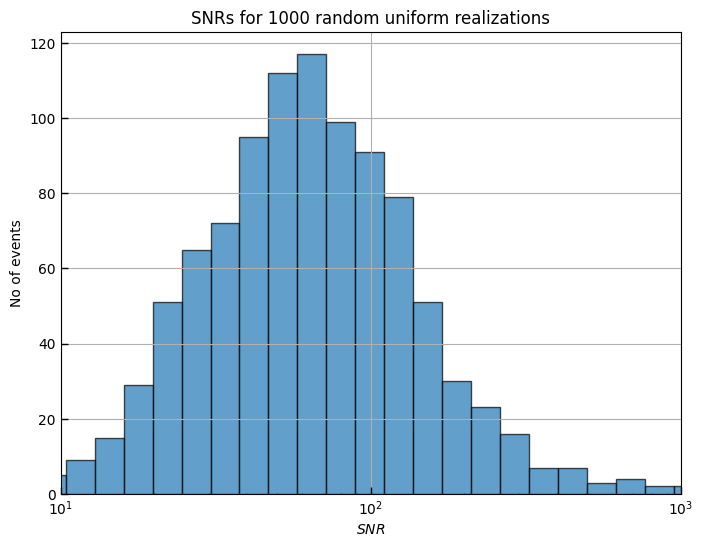

In [20]:
import matplotlib.pyplot as plt
#%matplotlib widget

# Plotting the histogram
plt.figure(figsize=(8, 6))

# Determine the range of SNR values
min_snr = np.min(snrs)
max_snr = np.max(snrs)

log_min_snr = np.log10(min_snr)
log_max_snr = np.log10(max_snr)
num_bins = 50  # Adjust the number of bins as needed
bin_edges = np.logspace(log_min_snr, log_max_snr, num=num_bins)

# plt.hist(snrsEcc, bins=80, edgecolor='black', alpha=0.7)
plt.hist(snrs, bins=bin_edges, edgecolor='black', alpha=0.7)

plt.xlim([10,1000])
# plt.ylim([1,None])

plt.title('SNRs for 1000 random uniform realizations')

plt.xscale('log')
# plt.yscale('log')

plt.xlabel('$SNR$')
plt.ylabel('No of events')

# plt.tick_params(width=1, color="black", direction="in", which="minor", right="true", length=7.5)
# plt.tick_params(width=1, color="black", direction="in", which="major", right="true", length=10)

plt.tick_params(width=1, color="black", direction="in", which="minor", bottom="true", length=0.5)
plt.tick_params(width=1, color="black", direction="in", which="major", bottom="true", length=5)

plt.grid(True)

# plt.savefig("Hist_eccSNR_1000Realz_ETVCEHLflow3_m1m25to400_e0p01to0p2_z0to20.pdf", dpi=500, bbox_inches='tight')
plt.show()
# plt.close('all')